In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
# Use the file with embedding features
FEATURES_PREPPED_FILE = "features_prepped_with_neighbors.csv"
TRAIN_TEST_SPLIT = 0.9
VAL_TEST_SPLIT = 0.9
START_DATE = datetime(2025,9,8) + timedelta(days=28)
BAD_FEATURES = []
TOP_100 = [2637208, 2674067, 2674069, 2677746, 2691590, 2739813, 2813189, 2813194, 2813195, 2819449, 2822887, 2840431, 2841189, 2855586, 2855595, 2857178, 3690505, 3690510, 4039724, 4189521, 4463773, 4580598, 5192206, 5192221, 5192225, 5245545, 5257669, 5658823, 5664444, 5683132, 5683135, 5683137, 5698506, 5698507, 5703921, 5710675, 5730396, 5823149, 5823150, 5850773, 5851707, 5955504, 5955510, 5955515, 5973485, 6049412, 6049413, 6256793, 6451779, 7210406, 7249979, 7379752, 7622814, 7622840, 7635753, 7653413, 7855462, 7869313, 7915951, 7917434, 7917436, 7922326, 8152638, 8152776, 8152803, 8152804, 8217944, 8422222, 8596633, 8858060, 8880222, 8966982, 8971859, 8972128, 9209729, 9245542, 9256674, 9603028, 9603030, 9603032, 9603035, 9656727, 9680118, 9724035, 10041062, 10041066, 10648067, 11061680, 11562016, 11562019, 12120522, 12168743, 12376820, 12376825, 12681178, 12744603, 13419273, 13536691, 14158330, 14234253]

In [3]:
df = pd.read_csv(FEATURES_PREPPED_FILE)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(by='date')
df = df[df['date'] >= START_DATE]
df

/tmp/ipykernel_791530/635287496.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


,gemrate_id,date,price,grade,half_grade,source_ebay,source_fanatics_weekly,source_fanatics_premier,seller_popularity,grade_co_BCCG,...,neighbor_5_score,neighbor_5_sale_1_price,neighbor_5_sale_1_ndays,neighbor_5_sale_1_index_price,neighbor_5_sale_2_price,neighbor_5_sale_2_ndays,neighbor_5_sale_2_index_price,neighbor_5_sale_3_price,neighbor_5_sale_3_ndays,neighbor_5_sale_3_index_price
428892,f9bb8665bf0e281bd59cc47d978c898e2e438b6f,2025-10-06,8.794825,9.0,0.0,1,0,0,NaN,0,...,0.728239,2.484907,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364357,d71306cdbed712bc4c68a1a7116935e4d07c9dc5,2025-10-06,8.779557,9.0,0.0,1,0,0,NaN,0,...,1.747223,7.346010,2.0,1215.232065,7.499977,10.0,1217.070308,7.003974,16.0,1041.983763
69894,2354a4e2bea9bec94bc97ab6a2e9c9fbc652c7c2,2025-10-06,10.878047,10.0,0.0,1,0,0,NaN,0,...,0.824587,9.413281,1.0,1212.260459,9.239899,1.0,1212.260459,9.282661,3.0,1208.995414
286792,a450cef88928eeabc3dd51898b4fd3ed0b0cc85d,2025-10-06,7.313220,10.0,0.0,1,0,0,NaN,0,...,0.791791,2.821379,7.0,NaN,3.015535,7.0,NaN,3.273364,7.0,NaN
69893,2354a4e2bea9bec94bc97ab6a2e9c9fbc652c7c2,2025-10-06,10.214642,10.0,0.0,1,0,0,NaN,0,...,0.824587,9.413281,1.0,1212.260459,9.239899,1.0,1212.260459,9.282661,3.0,1208.995414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81886,2caa04bfeb6d3db1c8901e3262a5fd59ee044275,2026-01-09,6.396930,10.0,1.0,1,0,0,NaN,0,...,0.860590,7.740664,4.0,1108.222177,3.126761,25.0,NaN,7.003065,29.0,1043.464826
132661,4cdb929e92bd07d4c22e74f382a2ae9352855771,2026-01-09,9.844268,10.0,0.0,1,0,0,NaN,0,...,0.735351,8.006368,18.0,1055.380362,8.070906,20.0,1049.927921,7.863267,40.0,1055.560462
132660,4cdb929e92bd07d4c22e74f382a2ae9352855771,2026-01-09,9.235033,10.0,0.0,1,0,0,NaN,0,...,0.735351,8.006368,18.0,1055.380362,8.070906,20.0,1049.927921,7.863267,40.0,1055.560462
332653,c20259c57c80b35a3d9d4d0666438c901e3edb1a,2026-01-09,10.295530,10.0,0.0,1,0,0,NaN,0,...,1.848394,10.010097,3.0,1105.393771,9.987369,11.0,1084.629867,5.575949,18.0,NaN


In [4]:
feature_cols = [col for col in df.columns if col not in ['gemrate_id', 'spec_id', 'date', 'price'] and col not in BAD_FEATURES]
print(f"Total features: {len(feature_cols)}")

Total features: 199


In [5]:
train_df = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT)]
test_df = df.iloc[int(len(df) * TRAIN_TEST_SPLIT):]
val_df = test_df.iloc[:int(len(test_df) * VAL_TEST_SPLIT)]
test_df = test_df.iloc[int(len(test_df) * VAL_TEST_SPLIT):]

val_df = val_df.loc[val_df["prev_1_price"].isna()]
# val_df = val_df.dropna(subset=['neighbor_1_avg_price'])
test_df = test_df.loc[test_df["prev_1_price"].isna()]
# test_df = test_df.dropna(subset=['emb_neighbor_1_price'])
# val_df = val_df.loc[val_df["spec_id"].isin(TOP_100)]
# test_df = test_df.loc[test_df["spec_id"].isin(TOP_100)]
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
val_df["date"].min()

Train: 186932, Val: 1927, Test: 156


Timestamp('2025-12-19 00:00:00')

In [6]:
X_train = train_df[feature_cols].copy()
y_train = train_df['price'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['price'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['price'].copy()

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {len(feature_cols)}")

Training set: 186932 samples
Validation set: 1927 samples
Test set: 156 samples
Number of features: 199


In [7]:
model = XGBRegressor(device='cuda')

# Define parameter grid
param_grid = {
    'max_depth': [10],
    'learning_rate': [0.075],
    'n_estimators': [150],
    'min_child_weight': [30],
    'subsample': [0.9],
    'colsample_bytree': [1.0],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [5],
    'colsample_bylevel': [0.7],
    'max_delta_step': [0],
}

best_score = 99999
best_grid = {}
for g in ParameterGrid(param_grid):
    model.set_params(**g)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_val_pred = np.exp(y_val_pred)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)
    print(f"MAPE: {mape:.2%}")
    if mape < best_score:
        best_score = mape
        best_grid = g
    print(f"Best MAPE: {best_score:.2%}")

print("Best MAPE: %0.5f" % best_score)
print("Best Grid:", best_grid)

MAPE: 74118.34%
Best MAPE: 74118.34%
Best MAPE: 741.18342
Best Grid: {'colsample_bylevel': 0.7, 'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.075, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 30, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.9}


/root/sync/ava/collector_crypt/.venv/lib/python3.13/site-packages/xgboost/core.py:774: UserWarning: [00:36:45] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [8]:
best_model = XGBRegressor(device='cuda')
best_model.set_params(**best_grid)
best_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.7
,colsample_bynode,None
,colsample_bytree,1.0
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [9]:
y_val = np.exp(y_val)
y_val_pred = best_model.predict(X_val)
y_val_pred = np.exp(y_val_pred)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

simple_percent_error = (np.abs(X_val["prev_1_price"].values - y_val.values) / y_val.values) * 100
simple_percent_error_series = pd.Series(simple_percent_error, name='simple_percent_error')
percent_error = (np.abs(y_val_pred - y_val.values) / y_val.values) * 100
percent_error_series = pd.Series(percent_error, name='percent_error')

print("Validation Metrics:")
print(f"  RMSE: ${val_rmse:,.2f}")
print(f"  MAE:  ${val_mae:,.2f}")
print(f"  MAPE: {val_mape:.2%}")
print(f"  R²:   {val_r2:.4f}")

print("\nSimple Percent Error Percentiles:")
print(simple_percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

print("\nPercent Error Percentiles:")
print(percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

Validation Metrics:
  RMSE: $95,955.16
  MAE:  $11,198.85
  MAPE: 61.22%
  R²:   0.1632

Simple Percent Error Percentiles:
count    0.0
mean     NaN
std      NaN
min      NaN
10%      NaN
20%      NaN
30%      NaN
40%      NaN
50%      NaN
60%      NaN
70%      NaN
80%      NaN
90%      NaN
max      NaN
Name: simple_percent_error, dtype: float64

Percent Error Percentiles:
count    1927.000000
mean       61.215211
std        72.191065
min         0.021174
10%         8.937220
20%        17.170519
30%        26.271316
40%        34.255986
50%        44.253132
60%        56.002801
70%        69.356385
80%        84.456199
90%       117.667719
max       828.458862
Name: percent_error, dtype: float64


In [10]:
y_test = np.exp(y_test)
y_test_pred = best_model.predict(X_test)
y_test_pred = np.exp(y_test_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

simple_percent_error = (np.abs(X_test["prev_1_price"].values - y_test.values) / y_test.values) * 100
simple_percent_error_series = pd.Series(simple_percent_error, name='simple_percent_error')
percent_error = (np.abs(y_test_pred - y_test.values) / y_test.values) * 100
percent_error_series = pd.Series(percent_error, name='percent_error')

print("Test Metrics:")
print(f"  RMSE: ${test_rmse:,.2f}")
print(f"  MAE:  ${test_mae:,.2f}")
print(f"  MAPE: {test_mape:.2%}")
print(f"  R²:   {test_r2:.4f}")

print("\nSimple Percent Error Percentiles:")
print(simple_percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

print("\nPercent Error Percentiles:")
print(percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

Test Metrics:
  RMSE: $15,286.77
  MAE:  $7,051.24
  MAPE: 50.89%
  R²:   -0.0504

Simple Percent Error Percentiles:
count    0.0
mean     NaN
std      NaN
min      NaN
10%      NaN
20%      NaN
30%      NaN
40%      NaN
50%      NaN
60%      NaN
70%      NaN
80%      NaN
90%      NaN
max      NaN
Name: simple_percent_error, dtype: float64

Percent Error Percentiles:
count    156.000000
mean      50.887670
std       39.137055
min        1.228708
10%       10.122375
20%       20.283061
30%       29.733331
40%       35.986552
50%       43.354389
60%       55.474015
70%       64.999370
80%       70.995613
90%       90.159855
max      227.259969
Name: percent_error, dtype: float64


In [11]:
y_test

103999     4800.0
137738    12939.0
298493     1700.0
23204       500.0
355451    14550.0
           ...   
125366     2700.0
221957     2100.0
338484     2600.0
250922    18750.0
81886       600.0
Name: price, Length: 156, dtype: float64

In [12]:
y_test_pred

array([ 3706.492  , 10704.326  ,  5017.72   ,  1581.3958 ,  5875.6763 ,
        1534.7737 ,  2606.965  ,  3598.1433 , 12095.617  ,  4232.49   ,
        7073.1104 ,  4079.572  ,  4370.915  ,  2879.6653 ,  9531.954  ,
        1464.4298 ,  2781.293  ,  4668.3623 ,  3997.1538 ,  9910.767  ,
        3573.3684 ,  5391.0273 ,  2334.2288 ,  3406.2998 ,  4431.439  ,
        4357.422  ,  4997.157  ,  1801.0416 ,  3452.074  ,  9071.269  ,
        1299.2993 ,   885.82587, 10948.04   , 11433.677  ,  3255.2336 ,
       20412.613  ,  1825.4618 ,  7278.993  ,  5747.262  , 13805.78   ,
       17747.643  ,  9032.258  ,  8295.18   ,  2307.5361 ,  7089.197  ,
        3258.3242 ,  6773.319  ,  3937.3345 ,  6574.6934 ,  3029.7239 ,
        2765.7708 , 20540.814  ,  7680.7324 ,  7466.975  ,  1844.9691 ,
       11596.542  , 22196.83   ,  3007.6519 ,  9855.892  ,  2960.2122 ,
       67142.19   ,  1416.7445 ,  1679.2484 ,  3291.58   ,  9506.707  ,
        4976.688  ,  3056.8545 ,  4276.297  ,  1598.6783 ,  2310

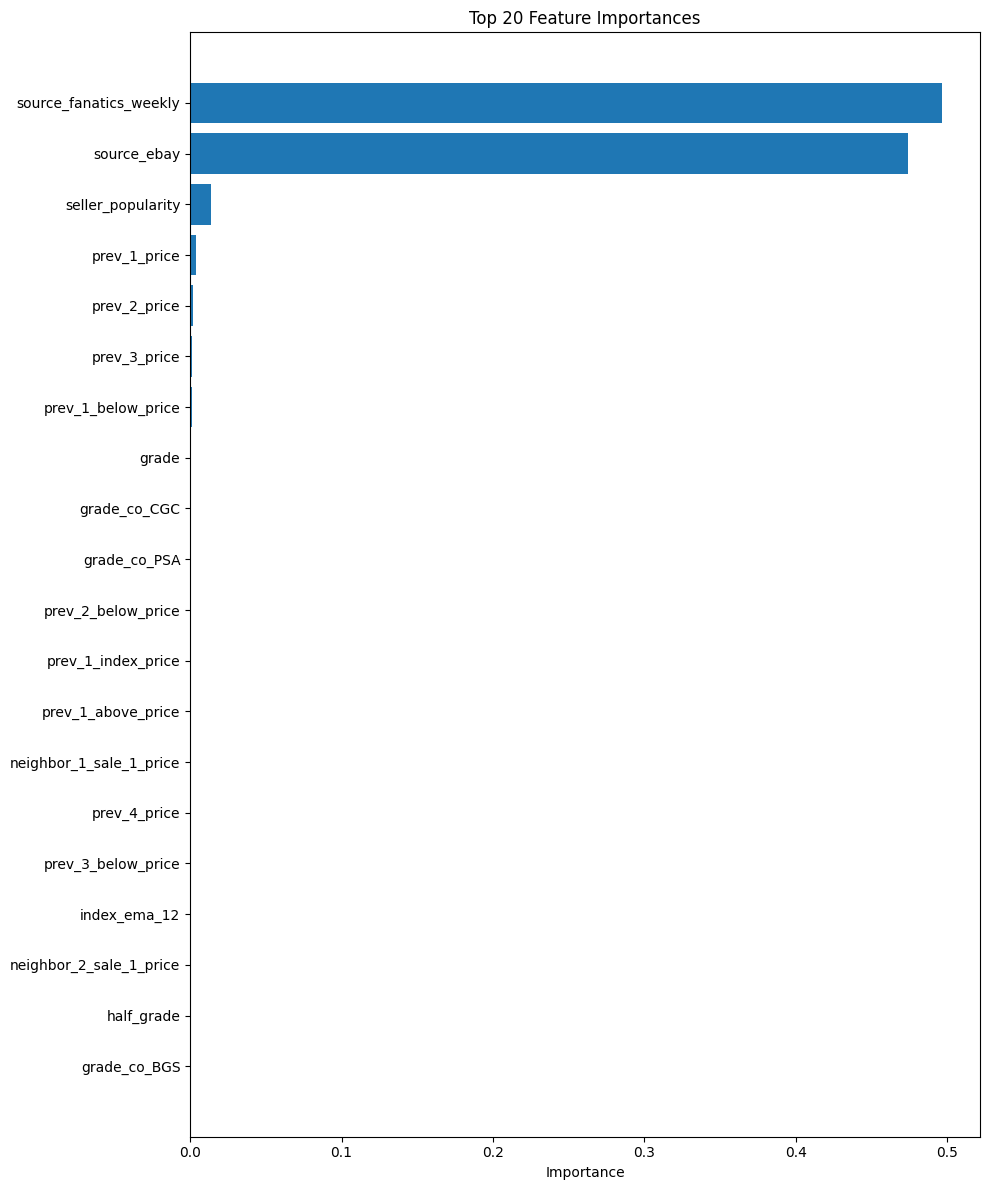

,feature,importance
3,source_fanatics_weekly,0.496709
2,source_ebay,0.474243
5,seller_popularity,0.013843
15,prev_1_price,0.003904
22,prev_2_price,0.002075
29,prev_3_price,0.001396
109,prev_1_below_price,0.000976
0,grade,0.000421
9,grade_co_CGC,0.000393
12,grade_co_PSA,0.000326


In [13]:
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importance_df.head(20)

In [14]:
importance_df["importance_cumsum"] = importance_df["importance"].cumsum()
importance_df

,feature,importance,importance_cumsum
3,source_fanatics_weekly,0.496709,0.496709
2,source_ebay,0.474243,0.970953
5,seller_popularity,0.013843,0.984795
15,prev_1_price,0.003904,0.988700
22,prev_2_price,0.002075,0.990775
...,...,...,...
8,grade_co_BVG,0.000000,1.000000
4,source_fanatics_premier,0.000000,1.000000
6,grade_co_BCCG,0.000000,1.000000
11,grade_co_Other,0.000000,1.000000


In [15]:
bad_features = importance_df[importance_df["importance_cumsum"] > 0.95]["feature"]
list(bad_features)

['source_ebay',
 'seller_popularity',
 'prev_1_price',
 'prev_2_price',
 'prev_3_price',
 'prev_1_below_price',
 'grade',
 'grade_co_CGC',
 'grade_co_PSA',
 'prev_2_below_price',
 'prev_1_index_price',
 'prev_1_above_price',
 'neighbor_1_sale_1_price',
 'prev_4_price',
 'prev_3_below_price',
 'index_ema_12',
 'neighbor_2_sale_1_price',
 'half_grade',
 'grade_co_BGS',
 'prev_1_above_seller_popularity',
 'avg_price_4w_ago',
 'prev_5_price',
 'avg_price_2w_ago',
 'neighbor_3_sale_1_price',
 'avg_price_3w_ago',
 'prev_1_days_ago',
 'index_ema_26',
 'prev_1_grade_co_CGC',
 'prev_1_half_grade',
 'prev_2_index_price',
 'neighbor_1_sale_3_price',
 'neighbor_4_sale_1_price',
 'prev_1_grade_co_BGS',
 'prev_5_below_price',
 'prev_2_above_price',
 'index_change_1d',
 'prev_2_grade_co_BGS',
 'neighbor_5_score',
 'prev_1_above_grade_co_BGS',
 'prev_4_below_price',
 'neighbor_2_sale_3_price',
 'neighbor_5_sale_1_price',
 'prev_1_above_days_ago',
 'prev_1_grade_co_PSA',
 'prev_5_above_price',
 'index_

## Prediction Intervals with Quantile Regression

Train additional XGBoost models to predict lower and upper bounds using quantile regression.
This provides uncertainty estimates for each prediction.

In [16]:
# Train quantile regression models for prediction intervals
# Lower bound (10th percentile) and upper bound (90th percentile)

LOWER_QUANTILE = 0.1
UPPER_QUANTILE = 0.9

# Create quantile regression models using the same hyperparameters as the best model
quantile_params = best_grid.copy()

# Train lower bound model
model_lower = XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=LOWER_QUANTILE,
    device='cuda',
    **quantile_params
)
model_lower.fit(X_train, y_train)
print(f"Lower bound model (q={LOWER_QUANTILE}) trained")

# Train upper bound model
model_upper = XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=UPPER_QUANTILE,
    device='cuda',
    **quantile_params
)
model_upper.fit(X_train, y_train)
print(f"Upper bound model (q={UPPER_QUANTILE}) trained")

Lower bound model (q=0.1) trained
Upper bound model (q=0.9) trained


In [17]:
# Generate prediction intervals for test set
y_test_pred_lower = np.exp(model_lower.predict(X_test))
y_test_pred_upper = np.exp(model_upper.predict(X_test))
y_test_pred_median = y_test_pred  # Use point prediction as median

# Calculate interval coverage (percentage of actual values within predicted interval)
in_interval = (y_test.values >= y_test_pred_lower) & (y_test.values <= y_test_pred_upper)
coverage = in_interval.mean()

# Calculate average interval width
interval_width = y_test_pred_upper - y_test_pred_lower
avg_interval_width = interval_width.mean()
relative_interval_width = (interval_width / y_test_pred_median).mean()

print(f"\nPrediction Interval Metrics (Test Set):")
print(f"  Target Coverage: {(UPPER_QUANTILE - LOWER_QUANTILE) * 100:.0f}%")
print(f"  Actual Coverage: {coverage * 100:.1f}%")
print(f"  Average Interval Width: ${avg_interval_width:,.2f}")
print(f"  Relative Interval Width: {relative_interval_width * 100:.1f}% of predicted price")


Prediction Interval Metrics (Test Set):
  Target Coverage: 80%
  Actual Coverage: 82.7%
  Average Interval Width: $16,748.53
  Relative Interval Width: 333.6% of predicted price


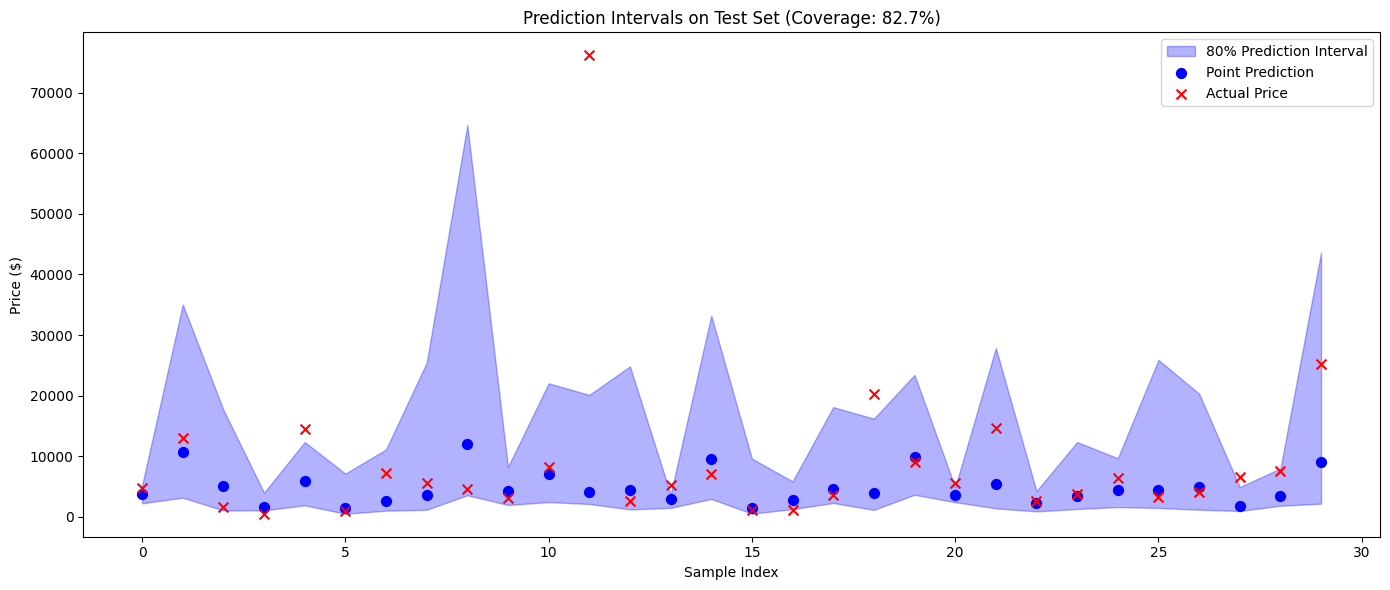

In [18]:
# Visualize prediction intervals for a sample of test predictions
n_samples = min(30, len(y_test))
sample_indices = np.arange(n_samples)

plt.figure(figsize=(14, 6))

# Plot prediction intervals
plt.fill_between(sample_indices, 
                 y_test_pred_lower[:n_samples], 
                 y_test_pred_upper[:n_samples], 
                 alpha=0.3, color='blue', label=f'{int((UPPER_QUANTILE-LOWER_QUANTILE)*100)}% Prediction Interval')

# Plot point predictions
plt.scatter(sample_indices, y_test_pred_median[:n_samples], 
            color='blue', s=50, zorder=3, label='Point Prediction')

# Plot actual values
plt.scatter(sample_indices, y_test.values[:n_samples], 
            color='red', s=50, marker='x', zorder=4, label='Actual Price')

plt.xlabel('Sample Index')
plt.ylabel('Price ($)')
plt.title(f'Prediction Intervals on Test Set (Coverage: {coverage*100:.1f}%)')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Create a summary DataFrame with predictions and intervals
predictions_df = pd.DataFrame({
    'actual_price': y_test.values,
    'predicted_price': y_test_pred_median,
    'lower_bound': y_test_pred_lower,
    'upper_bound': y_test_pred_upper,
    'interval_width': interval_width,
    'in_interval': in_interval
})

predictions_df['error'] = predictions_df['actual_price'] - predictions_df['predicted_price']
predictions_df['percent_error'] = (np.abs(predictions_df['error']) / predictions_df['actual_price']) * 100

print("\nPredictions with Intervals:")
predictions_df.head(15)


Predictions with Intervals:


,actual_price,predicted_price,lower_bound,upper_bound,interval_width,in_interval,error,percent_error
0,4800.0,3706.491943,2227.093506,5216.205566,2989.112061,True,1093.508057,22.781418
1,12939.0,10704.326172,3153.062256,35051.671875,31898.609375,True,2234.673828,17.270839
2,1700.0,5017.720215,1049.191528,17655.824219,16606.632812,True,-3317.720215,195.160013
3,500.0,1581.395752,1066.317261,3984.316895,2917.999512,False,-1081.395752,216.279150
4,14550.0,5875.676270,1898.632324,12336.851562,10438.218750,False,8674.323730,59.617345
5,1000.0,1534.773682,498.607239,7130.733887,6632.126465,True,-534.773682,53.477368
6,7266.0,2606.965088,1018.593506,11126.695312,10108.101562,True,4659.034912,64.121042
7,5600.0,3598.143311,1159.695190,25439.375000,24279.679688,True,2001.856689,35.747441
8,4600.0,12095.617188,3558.476562,64641.226562,61082.750000,True,-7495.617187,162.948200
9,3100.0,4232.490234,1952.632690,8234.755859,6282.123047,True,-1132.490234,36.531943
